In [22]:
from patsy import dmatrix
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [23]:
try:
    from utils import split_data, load_data, DATA_PATH, transform, inverse_transform, BoxCoxTransformer
except ImportError:  # notebook being ran in child dir
    import sys; sys.path.insert(0, '..')  # add parent to path
    from utils import split_data, load_data, DATA_PATH, transform, inverse_transform, BoxCoxTransformer

In [24]:
df = load_data(DATA_PATH)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041 entries, 0 to 2040
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     2041 non-null   int64         
 1   Date                           2041 non-null   datetime64[ns]
 2   Site                           2041 non-null   object        
 3   Staff Reported Positive Tests  2041 non-null   int64         
 4   # of Currently Positive Staff  2041 non-null   int64         
 5    Staff Deaths                  2041 non-null   int64         
 6   Staff Recovered                2041 non-null   int64         
 7   Housing type                   2041 non-null   object        
 8   Isolation Inmates              2041 non-null   int64         
 9   Positive Inmates               2041 non-null   int64         
 10  Confirmed Inmate Deaths        2041 non-null   int64         
 11  Pending Results  

In [26]:
df.columns

Index(['Unnamed: 0', 'Date', 'Site', 'Staff Reported Positive Tests',
       '# of Currently Positive Staff', ' Staff Deaths', 'Staff Recovered',
       'Housing type', 'Isolation Inmates', 'Positive Inmates',
       'Confirmed Inmate Deaths', 'Pending Results', 'Recovered Inmates',
       'Daily Recovered', 'N1', 'N2', 'B.1.1.7 (Alpha)', 'B.1.351 (Beta)',
       'P.1 (Gamma)', 'B.1.617 (Delta)', 'B.1.427/B.1.429 (Epsilon)',
       'N679K/Q954H (Omicron)', 'Presumptive Cases',
       'Average Presumptive Cases', 'Y', 'X', 'housing_factor', 'site_factor'],
      dtype='object')

In [27]:
df["N_avg"] = (df.N1 + df.N2) / 2

In [28]:
x_col = "# of Currently Positive Staff"
y_col = "N_avg"
df_ = df.dropna(subset=[x_col, y_col]).copy()
# df_ = df_.loc[df_.N_avg < 50000]  # there is a really weird single point that is super out there that we remove

X = df_[[x_col]]  # dbl [[]] to keep as df for ease of plotting later (associated with col name, don't need to spec axis label)
y = df_[[y_col]]
X_transformed = transform(X)
y_transformed = transform(y)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=1234, 
    )

# Turn to df for same reason a above
X_train_detransformed = pd.DataFrame({x_col: inverse_transform(X_train, X).reshape(-1)})
X_test_detransformed = pd.DataFrame({x_col: inverse_transform(X_test, X).reshape(-1)})

y_train_detransformed = pd.DataFrame({y_col: inverse_transform(y_train, y).reshape(-1)})
y_test_detransformed = pd.DataFrame({y_col: inverse_transform(y_test, y).reshape(-1)})

               model          bic           aic     mse_train       mse_test
0  Linear Model (lm)  26913.87914  26908.547425  2.600255e+06  264855.358335


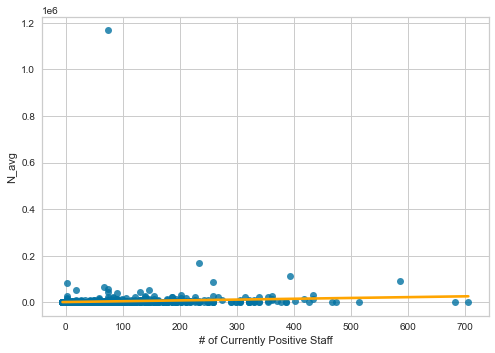

In [29]:
lm = sm.OLS(y_train, X_train).fit()

# Training data
pred_train = lm.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)

# Test data
pred_test = lm.predict(X_test)
mse_test =mean_squared_error(y_test, pred_test,)

# Save model results
model_results_lm = pd.DataFrame(
    {
    "model": "Linear Model (lm)",  
    "bic": lm.bic,
    "aic": lm.aic,
    "mse_train": [mse_train], 
    "mse_test": [mse_test],
    })
print(model_results_lm)

sns.regplot(x=X_train_detransformed[x_col], 
            y=y_train_detransformed[y_col],
            ci=None, 
            line_kws={"color": "orange"});

                   model           bic          aic     mse_train  \
0  Polynomial Model (pm)  26927.391665  26911.39652  2.600255e+06   

        mse_test  
0  264855.358335  


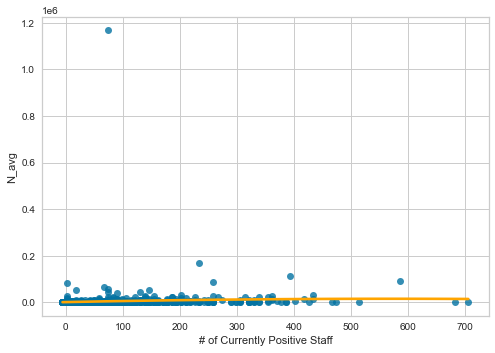

In [30]:
# polynomial degree 2
poly = PolynomialFeatures(2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

pm = sm.OLS(y_train, X_train_poly).fit()

# Training data
pred_train = pm.predict(X_train_poly)
rmse_train = mean_squared_error(y_train, 
                                pred_train)

# Test data
pred_test = pm.predict(X_test_poly)
rmse_test = mean_squared_error(y_test, 
                              pred_test)

# Save model results
model_results_pm = pd.DataFrame(
    {
    "model": "Polynomial Model (pm)",  
    "bic": pm.bic,
    "aic": pm.aic,
    "mse_train": [mse_train], 
    "mse_test": [mse_test],
    })

print(model_results_pm)

# plot
sns.regplot(x=X_train_detransformed[x_col], 
            y=y_train_detransformed[y_col],
            ci=None, 
            order=2, 
            line_kws={"color": "orange"});

               model           bic           aic     mse_train       mse_test
0  Cubic spline (cs)  26956.141802  26918.819798  2.597316e+06  259575.009612


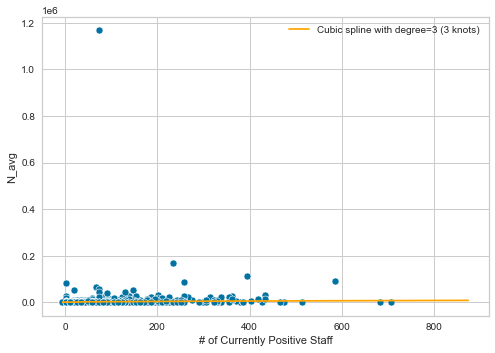

In [31]:
knots="2,4,6"
# Generating cubic spline with 3 knots at 10,20,30
transformed_x = dmatrix(
            f"bs(train, knots=({knots}), degree=3, include_intercept=False)", 
                {"train": X_train},return_type='dataframe')

cs = sm.GLM(y_train, transformed_x).fit()


# Training data
pred_train = cs.predict(dmatrix(f"bs(train, knots=({knots}), include_intercept=False)", {"train": X_train}, return_type='dataframe'))
mse_train = mean_squared_error(y_train, pred_train)

# Test data
pred_test = cs.predict(dmatrix(f"bs(test, knots=({knots}), include_intercept=False)", {"test": X_test}, return_type='dataframe'))
mse_test =mean_squared_error(y_test, pred_test)


# Save model results
model_results_cs = pd.DataFrame(
    {
    "model": "Cubic spline (cs)",
    "bic": cs.bic_llf,
    "aic": cs.aic,
    "mse_train": [mse_train], 
    "mse_test": [mse_test]
    })

print(model_results_cs)



# Create observations
xp = np.linspace(X_test.min(),X_test.max(), 100)
xp_detransformed = inverse_transform(xp.reshape(-1, 1), X)
# Make some predictions
pred = cs.predict(dmatrix(f"bs(xp, knots=({knots}), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred = inverse_transform(pred.to_frame(), X)
# plot
sns.scatterplot(x=X_train_detransformed[x_col], 
            y=y_train_detransformed[y_col],)

plt.plot(xp_detransformed, pred, label='Cubic spline with degree=3 (3 knots)', color='orange')
plt.legend();

                        model           bic          aic     mse_train  \
0  Natural cubic spline (ncs)  26927.548305  26911.55316  2.598563e+06   

        mse_test  
0  264326.925786  


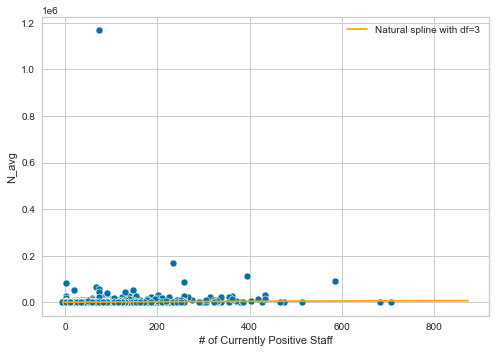

In [32]:

transformed_x3 = dmatrix("cr(train,df = 3)", {"train": X_train}, return_type='dataframe')

ncs = sm.GLM(y_train, transformed_x3).fit()

# Training data
pred_train = ncs.predict(dmatrix("cr(train, df=3)", {"train": X_train}, return_type='dataframe'))
mse_train = mean_squared_error(y_train, pred_train)

# Test data
pred_test = ncs.predict(dmatrix("cr(test, df=3)", {"test": X_test}, return_type='dataframe'))
mse_test =mean_squared_error(y_test, pred_test)

# Save model results
model_results_ncs = pd.DataFrame(
    {
    "model": "Natural cubic spline (ncs)",  
    "bic": ncs.bic_llf,
    "aic": ncs.aic,
    "mse_train": [mse_train], 
    "mse_test": [mse_test]
    })

print(model_results_ncs)

# Make predictions
pred = ncs.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))
pred = inverse_transform(pred.to_frame(), X)
# plot
sns.scatterplot(x=X_train_detransformed[x_col], 
            y=y_train_detransformed[y_col],)
plt.plot(xp_detransformed, pred, color='orange', label='Natural spline with df=3')
plt.legend();

In [33]:
results = pd.concat([model_results_lm, model_results_pm, model_results_cs, model_results_ncs], axis=0)

print(results)
results.to_csv(DATA_PATH.parent / "analysis/regression.csv")


                        model           bic           aic     mse_train  \
0           Linear Model (lm)  26913.879140  26908.547425  2.600255e+06   
0       Polynomial Model (pm)  26927.391665  26911.396520  2.600255e+06   
0           Cubic spline (cs)  26956.141802  26918.819798  2.597316e+06   
0  Natural cubic spline (ncs)  26927.548305  26911.553160  2.598563e+06   

        mse_test  
0  264855.358335  
0  264855.358335  
0  259575.009612  
0  264326.925786  


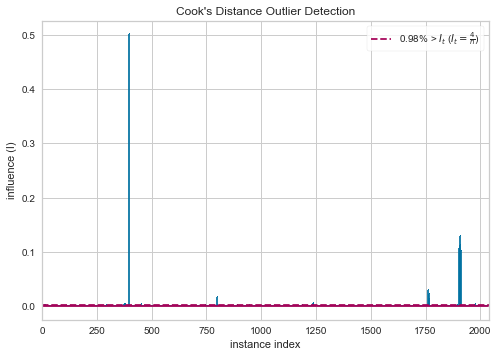

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [34]:
from yellowbrick.regressor import CooksDistance

# Instantiate and fit the cooks distances
cd = CooksDistance()
cd.fit(X, y[y_col])
cd.show()

In [35]:
cook_df = pd.DataFrame(dict(x=X[x_col], y=y[y_col], dist=cd.distance_, th=cd.influence_threshold_))

In [36]:
cook_df["outliers"] = cook_df.dist > cook_df.th

In [37]:
cook_df[cook_df.outliers].to_csv(DATA_PATH.parent / "analysis/cooks_distance.csv")